# In this notebook I will present my models which used for predictions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_csv('../creditcard.csv')

In [3]:
X = df.iloc[:, :-1]
y = df['Class']

In [4]:
und = RandomUnderSampler()
X_und, y_und = und.fit_resample(X, y)

In [5]:
Counter(y_und)

Counter({0: 492, 1: 492})

In [6]:
# Lets concat undersampled X and y
df_und = pd.concat([X_und, y_und], axis=1)
df_und.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,127652.0,2.006104,-0.127595,-1.015774,0.315159,-0.122936,-0.860338,0.046205,-0.149174,0.322701,...,-0.230339,-0.572987,0.349526,0.009194,-0.365216,0.179532,-0.073171,-0.070659,0.89,0
1,137537.0,1.936230,-0.294191,-0.570560,0.259339,-0.510745,-0.295500,-0.757714,0.049656,1.435306,...,0.002910,0.163598,0.267185,0.656542,-0.416091,-0.113799,0.042954,0.008152,29.99,0
2,135341.0,2.138432,-1.656127,-0.920124,-1.858596,-0.690444,1.205672,-1.601482,0.400276,-1.217118,...,-0.051860,0.431321,0.250905,-1.658277,-0.455512,-0.063947,0.068822,-0.071098,22.30,0
3,78158.0,1.049222,-0.401592,1.301356,0.997817,-1.398577,-0.501422,-0.609568,0.092222,1.051789,...,-0.047580,-0.119600,0.033856,0.723284,0.156430,0.294088,0.000344,0.038158,64.99,0
4,127734.0,2.057930,-0.327732,-2.726419,-0.775523,2.454901,3.198474,-0.451752,0.733267,0.487501,...,0.256416,0.789349,0.040269,0.738357,0.289607,-0.080795,0.002805,-0.064285,1.00,0


## Lets build our first Pipeline

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

In [42]:
algos = {
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB' : GaussianNB(),
    'LogisticRegression' : LogisticRegression(max_iter=200),
}

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_und, y_und)

In [44]:
for name, classifier in algos.items():
    pipeline = Pipeline(steps=[
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    y_predicted=pipeline.predict_proba(X_test)
    print(name,'ROC SCORE', roc_auc_score(y_test, y_predicted[:, 1]))

DecisionTreeClassifier ROC SCORE 0.8899391856160762
KNeighborsClassifier ROC SCORE 0.7258064516129034
GaussianNB ROC SCORE 0.9738894764674775
LogisticRegression ROC SCORE 0.9830777366472765


### As we can see Gaussian Naive Bayes along side with Logistic regression performed well on the data
### Now I will try ensemble methods

In [11]:
ensem = {
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LGBMClassifier' : LGBMClassifier(),
    'CatBoostClassifier' : CatBoostClassifier(verbose=False),
}

In [12]:
for name, classifier in ensem.items():
    pipe_en = Pipeline(steps=[
        ('classifier', classifier)
    ])
    pipe_en.fit(X_train, y_train)
    y_predicted=pipe_en.predict_proba(X_test)
    print(name,'ROC SCORE', roc_auc_score(y_test, y_predicted[:, 1]))

RandomForestClassifier ROC SCORE 0.9827472236911688
GradientBoostingClassifier ROC SCORE 0.9862837123215231
LGBMClassifier ROC SCORE 0.9866472765732417
CatBoostClassifier ROC SCORE 0.9842675832892649


## The accuracy might change depending on train test split so we will try cross validation 

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [48]:
models = {
    'GaussianNB' : GaussianNB(),
    'LogisticRegression' : LogisticRegression(max_iter=200 ),
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LGBMClassifier' : LGBMClassifier(),
    'CatBoostClassifier' : CatBoostClassifier(verbose=False),
}

In [49]:
results = []
names = []

for name, model in models.items():
    skfold = StratifiedKFold(n_splits=10)
    cv_results = cross_val_score(model, X_und, y_und, cv=skfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

GaussianNB: 0.957394 (0.038090)


C:\Users\egadi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: 0.947014 (0.067708)
RandomForestClassifier: 0.973531 (0.028196)
GradientBoostingClassifier: 0.954201 (0.053151)
LGBMClassifier: 0.976539 (0.016713)
CatBoostClassifier: 0.978341 (0.017686)


In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## In the EDA notebook we saw that dimensionality reduction techniques were useful. Let's try predicting on them

In [17]:
X_new = df_und[['V12', 'V14', 'V10', 'V11', 'V17']]
y_new = df_und.iloc[:, -1]

In [18]:
results = []
names = []

for name, model in models.items():
    skfold = StratifiedKFold(n_splits=10)
    pipeline = Pipeline(steps=[
        ('dim_red', PCA()),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    cv_results = cross_val_score(pipeline, X_new, y_new, cv=skfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

GaussianNB: 0.959539 (0.032323)


C:\Users\egadi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: 0.955950 (0.026540)
RandomForestClassifier: 0.957468 (0.035475)
GradientBoostingClassifier: 0.948928 (0.036886)
LGBMClassifier: 0.952370 (0.031205)
CatBoostClassifier: 0.955455 (0.028704)


In [19]:
results = []
names = []

for name, model in models.items():
    skfold = StratifiedKFold(n_splits=10)
    pipeline = Pipeline(steps=[
        ('dim_red', PCA()),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    cv_results = cross_val_score(pipeline, X_new, y_new, cv=skfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

GaussianNB: 0.959539 (0.032323)


C:\Users\egadi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: 0.955950 (0.026540)
RandomForestClassifier: 0.958044 (0.034374)
GradientBoostingClassifier: 0.949633 (0.037050)
LGBMClassifier: 0.952370 (0.031205)
CatBoostClassifier: 0.955455 (0.028704)


### Let's use Neural Networks 

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

In [22]:
for _ in range(10): 
    X_train, X_test, y_train, y_test = train_test_split(X_und, y_und)
    skfold = StratifiedKFold(n_splits=10)
    model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100,100, 100))
    cv_results = cross_val_score(model, X_new, y_new, cv=skfold, scoring='roc_auc')
    print(np.mean(cv_results))

0.9266813827571845
0.9344856309870886
0.922018325697626
0.9225968346522283
0.9110691378592254
0.9207705122865473
0.9278184089962516
0.9337392753019575
0.9313377759266972
0.9321424406497293


In [23]:
mlp_classifier = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100,100, 100), random_state=2)
mlp_classifier.fit(X_train, y_train)

C:\Users\egadi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(hidden_layer_sizes=(100, 100, 100), random_state=2,
              solver='lbfgs')

In [29]:
X_test.shape

(246, 30)

In [52]:
mlp_classifier.predict_proba(X_test).shape

(246, 2)

In [53]:
roc_auc_score(y_test, mlp_classifier.predict_proba(X_test)[:, 1])

0.5081967213114754

In [24]:
#predictions
y_pred_mlp = mlp_classifier.predict(X_test)

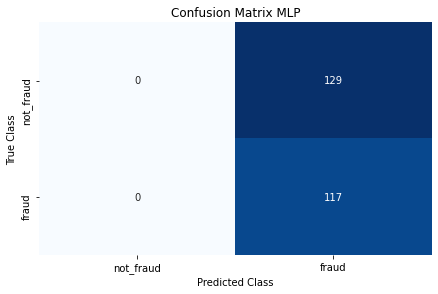

In [25]:
#CM matrix
matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
cm_mlp = pd.DataFrame(matrix_mlp, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_mlp, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix MLP"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

## Now try neural networks using tensorflow

In [77]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn import metrics

In [60]:
model = Sequential()
model.add(Dense(32, input_shape=(29,), activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(16, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(8, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(4, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(1, activation='sigmoid'))

In [61]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001) #optimizer

model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy']) #metrics


In [62]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1,mode='auto', 
                                                baseline=None, restore_best_weights=False)

In [63]:
history = model.fit(X_train.values, y_train.values, epochs = 6, batch_size=5, validation_split = 0.15, verbose = 0,
                    callbacks = [earlystopper])
history_dict = history.history

Text(0.5, 0, 'Epochs')

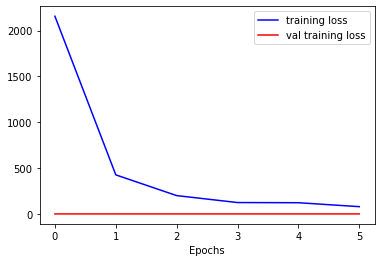

In [64]:
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

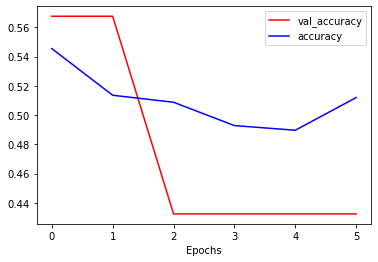

In [65]:
accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.plot(val_accuracy_values,'-r',label='val_accuracy')
plt.plot(accuracy_values,'-b',label='accuracy')
plt.legend()
plt.xlabel("Epochs")

In [66]:
y_pred_nn = model.predict_classes(X_test)


C:\Users\egadi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [69]:
#scores
print("Accuracy Neural Net:",metrics.accuracy_score(y_test, y_pred_nn))
print("Precision Neural Net:",metrics.precision_score(y_test, y_pred_nn))
print("Recall Neural Net:",metrics.recall_score(y_test, y_pred_nn))
print("F1 Score Neural Net:",metrics.f1_score(y_test, y_pred_nn))

Accuracy Neural Net: 0.5121951219512195
Precision Neural Net: 0.5121951219512195
Recall Neural Net: 1.0
F1 Score Neural Net: 0.6774193548387097


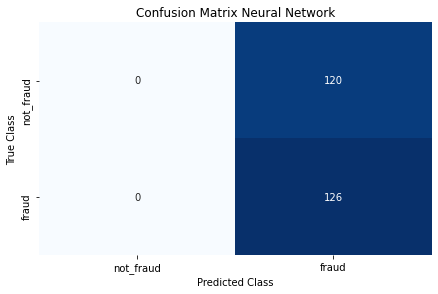

In [70]:
#CM matrix
matrix_nn = confusion_matrix(y_test, y_pred_nn)
cm_nn = pd.DataFrame(matrix_nn, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_nn, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix Neural Network"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [73]:
#AUC
y_pred_nn_proba = model.predict_proba(X_test)
fpr_keras, tpr_keras, thresholds_keras = metrics.roc_curve(y_test,y_pred_nn_proba)
auc_keras = metrics.auc(fpr_keras, tpr_keras)
print('AUC Neural Net: ', auc_keras)

AUC Neural Net:  0.5


C:\Users\egadi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [82]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping


## Before applying tensorflow lets scale the data

In [63]:
X=df.drop(columns=["Class"])
y=df["Class"]

In [71]:
names=X.columns
scaled_df = preprocessing.scale(X)
scaled_df = pd.DataFrame(scaled_df,columns=names)
scaled_df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


In [72]:
under = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = und.fit_resample(scaled_df, y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under)

In [73]:
X_under.shape

(984, 30)

In [104]:
clf = LogisticRegression(solver = 'lbfgs')
clf.fit(X_train, y_train)
test_pred = clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, test_pred))

0.9853261947253618


In [92]:
model = Sequential()
model.add(Dense(X_train.shape[1], activation = 'relu', input_dim = X_train.shape[1]))
model.add(BatchNormalization())

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

In [93]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy')

In [94]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

In [99]:
history = model.fit(x=X_train, y=y_train, batch_size = 256, epochs=200,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop])

Epoch 1/200
3/3 [==============================] - 0s 72ms/step - loss: 0.2638 - val_loss: 0.2461
Epoch 2/200
3/3 [==============================] - 0s 37ms/step - loss: 0.2616 - val_loss: 0.2459
Epoch 3/200
3/3 [==============================] - 0s 45ms/step - loss: 0.3001 - val_loss: 0.2456
Epoch 4/200
3/3 [==============================] - 0s 35ms/step - loss: 0.2835 - val_loss: 0.2455
Epoch 5/200
3/3 [==============================] - 0s 33ms/step - loss: 0.2955 - val_loss: 0.2452
Epoch 6/200
3/3 [==============================] - 0s 32ms/step - loss: 0.2517 - val_loss: 0.2447
Epoch 7/200
3/3 [==============================] - 0s 35ms/step - loss: 0.2618 - val_loss: 0.2445
Epoch 8/200
3/3 [==============================] - 0s 30ms/step - loss: 0.2866 - val_loss: 0.2442
Epoch 9/200
3/3 [==============================] - 0s 32ms/step - loss: 0.2449 - val_loss: 0.2439
Epoch 10/200
3/3 [==============================] - 0s 34ms/step - loss: 0.2563 - val_loss: 0.2437
Epoch 11/200
3/3 [=

Epoch 84/200
3/3 [==============================] - 0s 38ms/step - loss: 0.2487 - val_loss: 0.2283
Epoch 85/200
3/3 [==============================] - 0s 36ms/step - loss: 0.2189 - val_loss: 0.2280
Epoch 86/200
3/3 [==============================] - 0s 40ms/step - loss: 0.2286 - val_loss: 0.2277
Epoch 87/200
3/3 [==============================] - 0s 40ms/step - loss: 0.2188 - val_loss: 0.2275
Epoch 88/200
3/3 [==============================] - 0s 37ms/step - loss: 0.2123 - val_loss: 0.2272
Epoch 89/200
3/3 [==============================] - 0s 36ms/step - loss: 0.2382 - val_loss: 0.2268
Epoch 90/200
3/3 [==============================] - 0s 38ms/step - loss: 0.2265 - val_loss: 0.2267
Epoch 91/200
3/3 [==============================] - 0s 40ms/step - loss: 0.2247 - val_loss: 0.2263
Epoch 92/200
3/3 [==============================] - 0s 39ms/step - loss: 0.2277 - val_loss: 0.2262
Epoch 93/200
3/3 [==============================] - 0s 39ms/step - loss: 0.2269 - val_loss: 0.2261
Epoch 94/2

3/3 [==============================] - 0s 32ms/step - loss: 0.1930 - val_loss: 0.2166
Epoch 167/200
3/3 [==============================] - 0s 39ms/step - loss: 0.2072 - val_loss: 0.2164
Epoch 168/200
3/3 [==============================] - 0s 38ms/step - loss: 0.1958 - val_loss: 0.2165
Epoch 169/200
3/3 [==============================] - 0s 39ms/step - loss: 0.2158 - val_loss: 0.2164
Epoch 170/200
3/3 [==============================] - 0s 37ms/step - loss: 0.1892 - val_loss: 0.2163
Epoch 171/200
3/3 [==============================] - 0s 38ms/step - loss: 0.1996 - val_loss: 0.2161
Epoch 172/200
3/3 [==============================] - 0s 39ms/step - loss: 0.1800 - val_loss: 0.2158
Epoch 173/200
3/3 [==============================] - 0s 37ms/step - loss: 0.2105 - val_loss: 0.2155
Epoch 174/200
3/3 [==============================] - 0s 38ms/step - loss: 0.2007 - val_loss: 0.2153
Epoch 175/200
3/3 [==============================] - 0s 40ms/step - loss: 0.2002 - val_loss: 0.2151
Epoch 176/200


Text(0.5, 1.0, 'Loss for both Training and Validation')

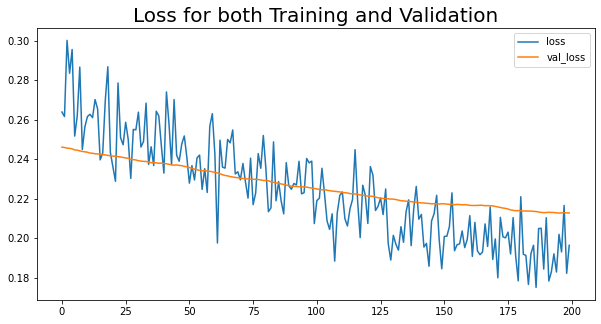

In [100]:
evaluation_metrics=pd.DataFrame(model.history.history)
evaluation_metrics.plot(figsize=(10,5))
plt.title("Loss for both Training and Validation", size = 20)

Text(0.5, 1.0, 'Loss for both Training and Validation')

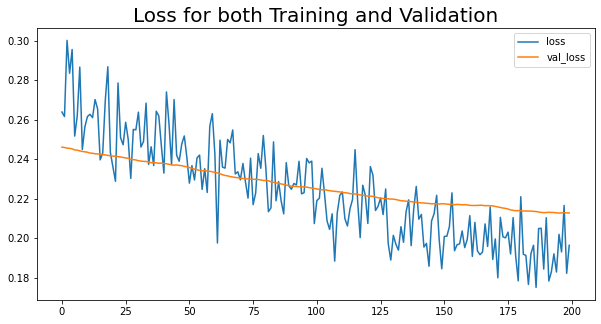

In [102]:
evaluation_metrics=pd.DataFrame(model.history.history)
evaluation_metrics.plot(figsize=(10,5))
plt.title("Loss for both Training and Validation", size = 20)

In [89]:
test_pred = model.predict(X_test)
print(roc_auc_score(y_test, test_pred))

0.9622579152620795


In [96]:
test_pred = model.predict(X_test)
print(roc_auc_score(y_test, test_pred))

0.9723048449996695


In [103]:
test_pred = model.predict(X_test)
print(roc_auc_score(y_test, test_pred))

0.9808976138541874


In [108]:
test_pred = model.predict(X)
print(roc_auc_score(y, test_pred))

0.4999548837178048


In [109]:
y_pred = model.predict_classes(X_test)

C:\Users\egadi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [110]:
cm_nn=confusion_matrix(y_test, y_pred)
cm_nn

array([[121,   2],
       [ 17, 106]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix Plotting for Neural Network model')

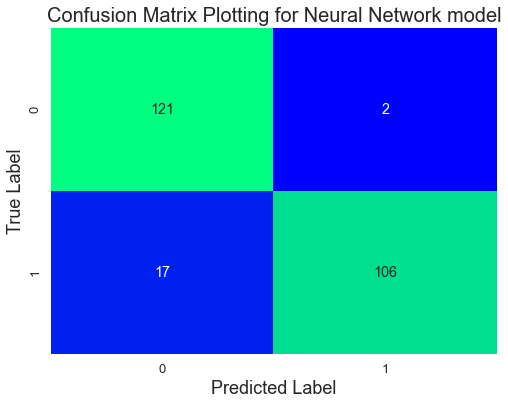

In [111]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm_nn, annot=True, fmt = 'g', cmap="winter", cbar = False)
plt.xlabel("Predicted Label", size = 18)
plt.ylabel("True Label", size = 18)
plt.title("Confusion Matrix Plotting for Neural Network model", size = 20)

In [81]:
model = Sequential()
model.add(Dense(32, input_shape=(30,), activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(16, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(8, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(4, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(1, activation='sigmoid'))

In [82]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001) #optimizer

model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy']) #metrics


In [83]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1,mode='auto', 
                                                baseline=None, restore_best_weights=False)

In [84]:
history = model.fit(X_train.values, y_train.values, epochs = 6, batch_size=5, validation_split = 0.15, verbose = 0,
                    callbacks = [earlystopper])
history_dict = history.history

Text(0.5, 0, 'Epochs')

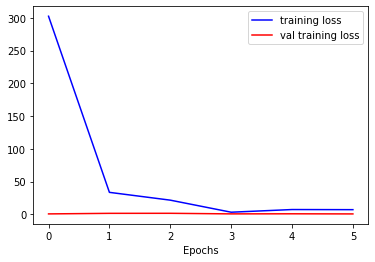

In [85]:
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

In [86]:
y_pred_nn = model.predict_classes(X_test)


C:\Users\egadi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [88]:
#AUC
y_pred_nn_proba = model.predict_proba(X_test)
fpr_keras, tpr_keras, thresholds_keras = metrics.roc_curve(y_test, y_pred_nn_proba)
auc_keras = metrics.auc(fpr_keras, tpr_keras)
print('AUC Neural Net: ', auc_keras)

AUC Neural Net:  0.5003644073411515


C:\Users\egadi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
